In [7]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
# tf.config.run_functions_eagerly(True)
from tensorflow.keras import backend as K
tf.__version__
# from tensorflow.keras.models import *
# from tensorflow.keras.layers import *
# from keras.optimizers import *
# from keras.preprocessing.image import ImageDataGenerator
# from keras.callbacks import Callback
# from keras.callbacks import ModelCheckpoint, CSVLogger



'2.3.0'

In [44]:
os.chdir('/content/drive/My Drive/GitHub Repositories/Seg-Gradient CAM')
dataDir = ('./datasets/TOP-VIEW HEADS DATASET')

images = np.load(os.path.join(dataDir, 'images(8 Bit).npy'))

# Z-score Normalization
mean = np.mean(images)
std = np.std(images)
images -= mean
images /= std


masks = np.load(os.path.join(dataDir, 'masks.npy'))
# Normalize masks to [0, 1]
masks /= 255. 

print('Images: {} | Dtype: {} | Max-Val: {} | Min-Val: {}'.format(images.shape, images.dtype, np.amax(images), np.amin(images)))
print('Masks: {} | Dtype: {} | Max-Val: {} | Min-Val: {}'.format(masks.shape, masks.dtype, np.amax(masks), np.amin(masks)))

images_train, images_test, masks_train, masks_test = train_test_split(images, masks, test_size=0.2, random_state=2020)
print('Train Images: {} | Train Masks: {}'.format(images_train.shape, masks_train.shape))
print('Validation Images: {} | Validation Masks: {}'.format(images_test.shape, masks_test.shape))


Images: (1815, 96, 128, 1) | Dtype: float32 | Max-Val: 0.5567962527275085 | Min-Val: -3.5179946422576904
Masks: (1815, 96, 128, 1) | Dtype: float32 | Max-Val: 1.0 | Min-Val: 0.0
Train Images: (1452, 96, 128, 1) | Train Masks: (1452, 96, 128, 1)
Validation Images: (363, 96, 128, 1) | Validation Masks: (363, 96, 128, 1)


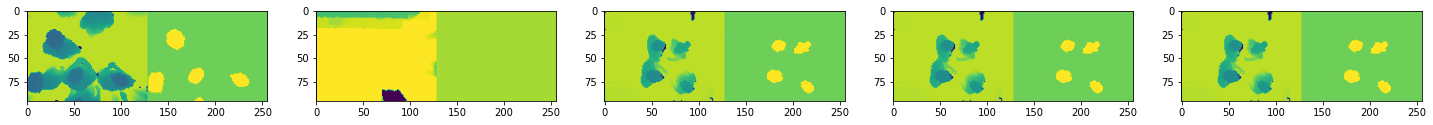

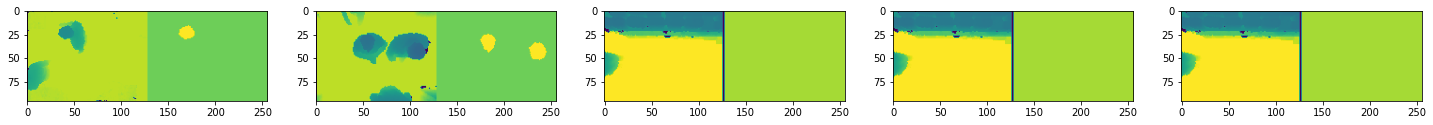

In [45]:
import matplotlib.pyplot as plt

def plotMask(images, masks):
    sample = []
    for i in range(10):
        left = images[i, :, :, 0]
        right = masks[i, :, :, 0]
        combined = np.hstack((left,right))
        sample.append(combined)
        
    for i in range(0, 10, 5):
        plt.figure(figsize=(25,10))
        
        plt.subplot(2, 5, 1+i)
        plt.imshow(sample[i])
        
        plt.subplot(2, 5, 2+i)
        plt.imshow(sample[i+1])
        
        
        plt.subplot(2, 5, 3+i)
        plt.imshow(sample[i+2])

        plt.subplot(2, 5, 4+i)
        plt.imshow(sample[i+2])

        plt.subplot(2, 5, 5+i)
        plt.imshow(sample[i+2])
        
        plt.show()

plotMask(images_test, masks_test)

In [11]:
img_rows = 96
img_cols = 128
smooth = 1

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def precision(y_true, y_pred):
    """ Precision metric. Only computes a batch-wise average of precision. Computes the precision, a metric for multi-label classification of
    how many selected items are relevant."""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """ Recall metric. Only computes a batch-wise average of recall. Computes the recall, a metric for multi-label classification of
    how many relevant items are selected. """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1score(y_true, y_pred):
    def recall(y_true, y_pred):
        """ Recall metric. Only computes a batch-wise average of recall. Computes the recall, a metric for multi-label classification of
        how many relevant items are selected. """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric. Only computes a batch-wise average of precision. Computes the precision, a metric for multi-label classification of
        how many selected items are relevant. """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    f1score =  2 * ((precision * recall) / (precision + recall))
    return f1score

def UNET_Architecture():
    inputs = tf.keras.layers.Input((img_rows, img_cols, 1))
    conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv1')(inputs)
    conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv2')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='block1_pool1')(conv1)

    conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv1')(pool1)
    conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv2')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='block2_pool1')(conv2)

    conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv1')(pool2)
    conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv2')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='block3_pool1')(conv3)

    conv4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block4_conv1')(pool3)
    conv4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block4_conv2')(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='block4_pool1')(conv4)

    conv5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(pool4)
    conv5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(conv5)

    up6 = tf.keras.layers.concatenate([tf.keras.layers.UpSampling2D(size=(2, 2), name='block6_upsample1')(conv5), conv4], axis=3, name = 'block6_concatenate1')
    conv6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block6_conv1')(up6)
    conv6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block6_conv2')(conv6)

    up7 = tf.keras.layers.concatenate([tf.keras.layers.UpSampling2D(size=(2, 2), name='block7_upsample1')(conv6), conv3], axis=3, name = 'block7_concatenate1')
    conv7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block7_conv1')(up7)
    conv7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block7_conv2')(conv7)

    up8 = tf.keras.layers.concatenate([tf.keras.layers.UpSampling2D(size=(2, 2), name='block8_upsample1')(conv7), conv2], axis=3, name = 'block8_concatenate1')
    conv8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block8_conv1')(up8)
    conv8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block8_conv2')(conv8)

    up9 = tf.keras.layers.concatenate([tf.keras.layers.UpSampling2D(size=(2, 2), name='block9_upsample1')(conv8), conv1], axis=3, name = 'block9_concatenate1')
    conv9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block9_conv1')(up9)
    conv9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block9_conv2')(conv9)

    conv10 = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid', name='output')(conv9)

    model = tf.keras.Model(inputs=[inputs], outputs=[conv10])
    return model

model = UNET_Architecture()
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef, 'accuracy', precision, recall, f1score])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 128, 1)] 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 96, 128, 32)  320         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 96, 128, 32)  9248        block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool1 (MaxPooling2D)     (None, 48, 64, 32)   0           block1_conv2[0][0]               
_______________________________________________________________________________________

In [14]:
saveDir = './saved Models/TOP VIEW HEADS'
if not os.path.exists(saveDir):
  os.makedirs(saveDir)

csv_logger = tf.keras.callbacks.CSVLogger('./saved Models/TOP VIEW HEADS/Training-Logs(heatmaps).csv')
checkpoint = tf.keras.callbacks.ModelCheckpoint('./saved Models/TOP VIEW HEADS/best-model(heatmaps).h5', verbose=1, monitor='val_accuracy',
                             save_best_only=True, mode='auto')  

model.fit(images_train, masks_train, batch_size=64, epochs=100, verbose=1, shuffle=True, validation_data = (images_test, masks_test),
          callbacks=[csv_logger, checkpoint])

Epoch 1/100
23/23 [==============================] - ETA: 0s - loss: -0.0742 - dice_coef: 0.0741 - accuracy: 0.0934 - precision: 0.0386 - recall: 0.9114 - f1score: 0.0741
Epoch 00001: val_accuracy improved from -inf to 0.08287, saving model to ./saved Models/TOP VIEW HEADS/best-model(heatmaps).h5
23/23 [==============================] - 9s 391ms/step - loss: -0.0742 - dice_coef: 0.0741 - accuracy: 0.0934 - precision: 0.0386 - recall: 0.9114 - f1score: 0.0741 - val_loss: -0.0772 - val_dice_coef: 0.0775 - val_accuracy: 0.0829 - val_precision: 0.0419 - val_recall: 0.9728 - val_f1score: 0.0803
Epoch 2/100
23/23 [==============================] - ETA: 0s - loss: -0.0766 - dice_coef: 0.0763 - accuracy: 0.2475 - precision: 0.0541 - recall: 0.9842 - f1score: 0.1020
Epoch 00002: val_accuracy improved from 0.08287 to 0.63246, saving model to ./saved Models/TOP VIEW HEADS/best-model(heatmaps).h5
23/23 [==============================] - 6s 252ms/step - loss: -0.0766 - dice_coef: 0.0763 - accuracy:

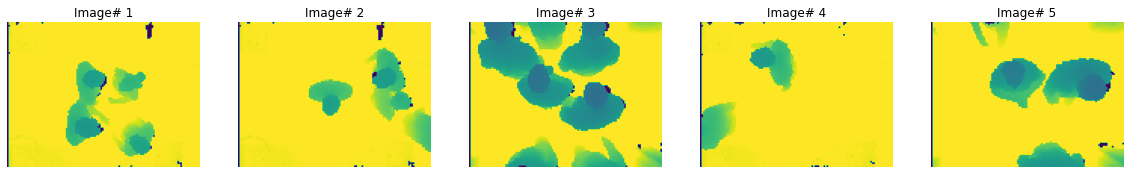

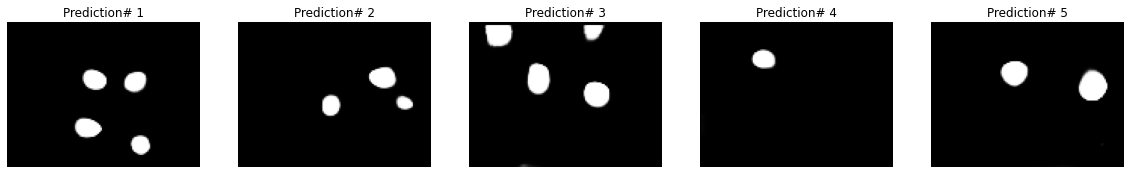

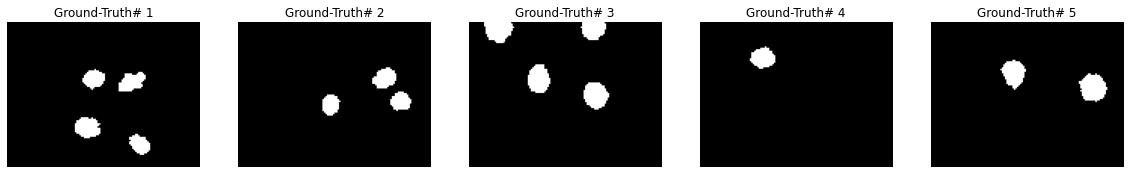

In [53]:
start_index = 2
end_index= 7

images_test_temp = images_test[start_index:end_index]
masks_test_temp = masks_test[start_index:end_index]

def plot_images(images_test, pred, masks_test):
  plt.figure(1, figsize = (20, 20))
  for i in range(5):
    plt.subplot(1, 5, i+1).set_title('Image# {}' .format(i+1))
    plt.imshow(images_test[i, :, :, 0])
    plt.axis('off')
  plt.figure(2, figsize = (20, 20))
  for i in range(5):
    plt.subplot(1, 5, i+1).set_title('Prediction# {}' .format(i+1))
    plt.imshow(pred[i, :, :, 0], cmap='gray')
    plt.axis('off')

  plt.figure(3, figsize = (20, 20))
  for i in range(5):
    plt.subplot(1, 5, i+1).set_title('Ground-Truth# {}' .format(i+1))
    plt.imshow(masks_test[i, :, :, 0], cmap='gray')
    plt.axis('off')

  plt.show()
  plt.close()

pred = model.predict(images_test_temp)
plot_images(images_test_temp, pred, masks_test_temp)

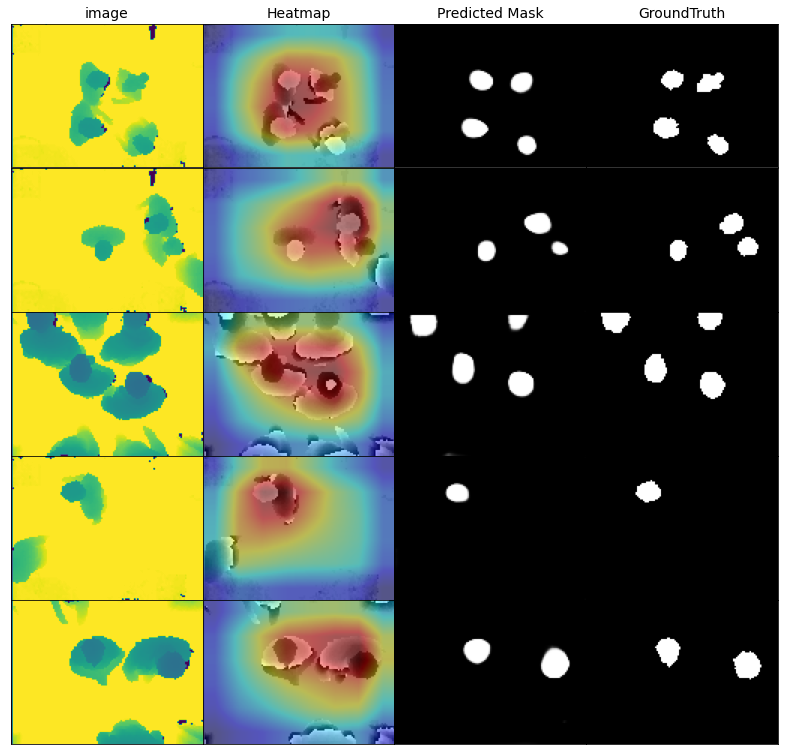

In [63]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

LAYER_NAME = 'block5_conv2'
model = tf.keras.models.load_model('./saved Models/TOP VIEW HEADS/best-model(heatmaps).h5',  compile=False)
grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])
classid = 1
def GetHeatMap(img):
  with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.array([img]))
    loss = predictions[:, classid]
    
  output = conv_outputs[0]
  grads = tape.gradient(loss, conv_outputs)[0]

  gate_f = tf.cast(output > 0, 'float32')
  gate_r = tf.cast(grads > 0, 'float32')
  guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

  weights = tf.reduce_mean(guided_grads, axis=(0, 1))

  cam = np.ones(output.shape[0: 2], dtype = np.float32)

  for i, w in enumerate(weights):
      cam += w * output[:, :, i]

  cam = cv2.resize(cam.numpy(), (128, 96))
  cam = np.maximum(cam, 0)
  cam = (cam - cam.min()) / (cam.max() - cam.min())

  cam = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
  cam = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)

  img = np.uint8(255*img).squeeze()
  img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)


  heatmap = cv2.addWeighted(img, 0.6, cam, 0.4, 0)
  return heatmap
  

titles = ['image', 'Heatmap', 'Predicted Mask', 'GroundTruth']
rows = 5
cols = 4

fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(11, 10.6), subplot_kw={'xticks': [], 'yticks': []})
for r in range(rows):
  # plot image
  ax[r][0].imshow(images_test_temp[r, :, :, 0])
  if r==0:
    ax[r][0].set_title(titles[0], fontsize=14)
  
  # plot heatmap
  ax[r][1].imshow(GetHeatMap(images_test_temp[r, :, :, 0].reshape(96, 128, 1)))
  if r==0:
    ax[r][1].set_title(titles[1], fontsize=14)
  
  # plot Predicted Mask
  ax[r][2].imshow(pred[r, :, :, 0], cmap='gray')
  if r==0:
    ax[r][2].set_title(titles[2], fontsize=14)

  # plot GroundTruth
  ax[r][3].imshow(masks_test_temp[r, :, :, 0], cmap='gray')
  if r==0:
    ax[r][3].set_title(titles[3], fontsize=14)


plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
fig.savefig('./ReadMe Images/unet-heatmaps-visualization.png')
plt.show()
plt.close()



